In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import reduce
from scipy.stats import linregress
from scipy import fftpack
from scipy.signal import detrend
from tqdm import tqdm
from scipy.optimize import root_scalar
from tqdm import tqdm
from scipy.optimize import curve_fit
from tsmoothie.smoother import LowessSmoother
import matplotlib
from statsmodels.tsa.stattools import acf, pacf
import mpl_interactions.ipyplot as iplt

The pdf  $f(x | x')$ is:

$$
f(x | x') = 2^{1 - \gamma} \cdot \gamma \cdot \left (\dfrac{x'}{x} \right )^{\gamma} \cdot\left ( 1 + \left ( \dfrac{1}{2 m} \right ) \right ) e^{\gamma(x' - 2x)}
$$

That in Log Space reads:

$$
f(x | x') = 2^{-\gamma} \cdot\gamma \cdot e^{\gamma \cdot \left ( -x + x' + e^{x'} - 2e^{x}  \right ) + ln \left ( 1 + 2 e^{x} \right )} 
$$

The cdf $F(x | x')$ in Log Space is instead is:

$$
F(x | x') = 1 - 2^{-\gamma} e^{\gamma \cdot \left ( -2 e^{x} + e^{x'} - x + x' \right  )}
$$


In [2]:
def pdfLogSpace(x, xb, gamma):
    return 2**(- gamma) * gamma * np.exp(gamma*(- x + xb + np.exp(xb) - 2*np.exp(x))+ np.log(1 + 2 * np.exp(x))) 

In [3]:
def cdfLogSpace(x, xb, gamma):
    return 1  - 2**(- gamma) * np.exp(gamma * (-2 * np.exp(x) + np.exp(xb) - x + xb))

In [4]:
def  drawCDF(unif, gamma, xb):
    #if np.sign(cdfLogSpace(-100, gamma = gamma, xb = xb) - unif) * np.sign(cdfLogSpace(50, gamma = gamma, xb = xb) - unif) == 1:
        #print(gamma, xb, unif, cdfLogSpace(-200, gamma = gamma, xb = xb) - unif, cdfLogSpace(50, gamma = gamma, xb = xb) - unif)
    return root_scalar(lambda t: cdfLogSpace(t, gamma = gamma, xb = xb) - unif, bracket=[-200, 50], method='brentq').root

In [5]:
def sizeAtBirth(gamma, xb0 = 1, seriesLength = 10000):
    uniformDraws = np.random.uniform(size = seriesLength)

    logSizes = np.zeros(seriesLength)
    logSizes[0] = xb0
    for i in range(1, seriesLength):
        logSizes[i] = drawCDF(unif = uniformDraws[i], gamma = gamma, xb = logSizes[i-1])

    return np.exp(logSizes)

In [7]:
np.random.seed(2)
seriesesLength = [20000]
#gammaValues = np.concatenate([np.linspace(0.001, 0.1, 25), np.linspace(0.11, 1.4, 50), np.linspace(1.41, 1/np.log(2), 25)])
gammaValues = np.linspace(1, 1/np.log(2), 100)
simulate = False
load = True
absorbingValues = []
startingPointsUniform = np.random.uniform(0, 1, len(gammaValues))
b = 10
def inverseCumM(u, b):
    return b * u**(10)
startingPoints = inverseCumM(startingPointsUniform, b)
if simulate:
    for seriesLength in tqdm(seriesesLength):
        meanSizesAtBirth = np.zeros(len(gammaValues))
        allSizes = np.zeros((len(gammaValues), seriesLength))
        for i, gamma in enumerate(gammaValues):
            #print(gamma)

            sizeBirth = sizeAtBirth(gamma = gamma, xb0 = startingPointsUniform[i], seriesLength = seriesLength)
            allSizes[i,:] = sizeBirth
            meanSizesAtBirth[i] = np.mean(sizeBirth)
            
            if np.allclose(sizeBirth[-1:], np.zeros(1)):
                treshold = i
                #print(f'The first case of an absorbing state is reached with omega2 = {omega2:.3}')
                absorbingValues.append(gamma)
                #break
        np.save(f'../data/sizeBirth{seriesLength}SingleTraitCloseCrit.npy', allSizes)
        #np.save(f'../data/meanSizeBirth{seriesLength}SingleTraitSamplingM.npy', meanSizesAtBirth)

In [8]:
if load:
    sizeBirth6000 = np.load(f'../data/longSampling/sizeBirth6000SingleTraitSamplingM.npy')
    sizeBirth10000 = np.load(f'../data/longSampling/sizeBirth10000SingleTraitSamplingM.npy')
    sizeBirth20000 = np.load(f'../data/longSampling/sizeBirth20000SingleTraitSamplingM.npy')

FileNotFoundError: [Errno 2] No such file or directory: '../data/longSampling/sizeBirth6000SingleTraitSamplingM.npy'

In [ ]:
criticalPoint = 1 / np.log(2)
def powerLaw(x, a, b):
    return a*x**b

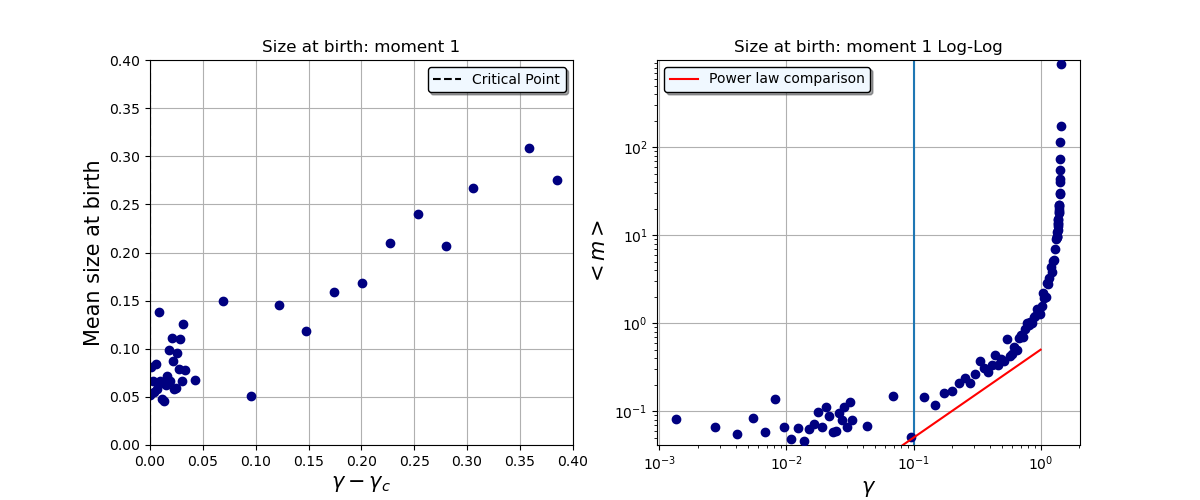

In [ ]:
#omega2BelowCritical = omega2Values[omega2Values < criticalPoint]
%matplotlib ipympl
cmap = matplotlib.cm.get_cmap('Blues')
colors = [cmap(np.linspace(0.2, 1, len(seriesesLength)))[i] for i in range(len(seriesesLength))]
fig, ax1  = plt.subplots(1,2, figsize = (12, 5))
ax, ax_ = ax1.flatten()

#meanSizesAtBirth = np.load(f'../data/meanSizeBirth20000SingleTraitSamplingM.npy')


def fY (x, k):
    title1 = f'Size at birth: moment {k}'
    ax.set_title(title1)
    yArr = sizeBirth20000**k
    
    y = np.mean(yArr, axis = 1)
    ax.set_ylim(bottom = -np.max(y)*0.01, top = 1.1*np.max(y))
    return y

controls = iplt.scatter(np.abs(gammaValues  - criticalPoint), fY, k = [1, 2, 3, 4,5 , 6], color = 'navy', zorder = 2, ax = ax)

#ax.scatter(gammaValues  - criticalPoint, meanSizesAtBirth , color = 'navy', zorder = 2)

xAxis = np.linspace(0, 1, 100)

#ax.plot(xAxis - criticalPoint, powerLaw(xAxis, *popt), label = f'Power law fit: $a = {popt[0]:.3}$, $b = {popt[1]:.3}$')
#ax.axvline(absorbingValue - criticalPoint, color = 'red', linestyle = '--', zorder = 2)
ax.axvline(0, color = 'black', linestyle = '--', label = 'Critical Point', zorder = 2)
ax.set_xlabel('$\gamma - \gamma_c$', fontsize = 15, zorder = 2)
ax.set_ylabel('Mean size at birth', fontsize = 15, zorder = 2)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', loc = 'upper right')
#ax.set_title('Mean size at birth for different size of the system', fontsize = 15)
ax.grid(zorder = 1)
powerLawValues = {'1':(1, -1), '2': (1.3, -2), '3': (2, -3) , '4':(4, -4), '5':(9, -5), '6':(25 ,-6)}
def fY2 (x, k):
    title2 = f'Size at birth: moment {k} Log-Log'
    ax_.set_title(title2)
    yArr2 = sizeBirth20000**k
    y2 = np.mean(yArr2, axis = 1)
    ax_.set_ylim(bottom = 0.9*np.min(y2), top = 1.1*np.max(y2))
    return y2


def fY3 (x, k):
    y3 = powerLaw(xAxis,*(0.5, 1))
    return y3

#ax_.plot(xAxis, powerLaw(xAxis,*powerLawValues[str(int(k))]), color = 'red', label = f'm = {k} line', zorder = 4)
_ = iplt.scatter(np.abs(gammaValues - criticalPoint), fY2, controls=controls, color = 'navy', ax = ax_, zorder = 3)

_ = iplt.plot(xAxis, fY3, controls=controls, color = 'red', ax = ax_, zorder = 3, label = 'Power law comparison')

ax_.set_xscale('log')
ax_.set_yscale('log')
#ax_.scatter(gammaValues, sizeBirth20000.mean(axis = 1), zorder = 2, color = 'navy')
ax_.set_xlabel('$\gamma $', fontsize = 15)
ax_.set_ylabel('$<m>$', fontsize = 15)
ax_.grid(zorder = 1)
#ax_.axvline(criticalPoint, color = 'black', linestyle = '--', label = 'Critical Point', zorder = 2)

#ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black')
#ax_.set_title('Mean size at birth for different generations, $log-log$')
ax_.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', loc = 'upper left')
ax_.axvline(0.1)
ax.set_xlim(left = 0, right = 0.4)
ax.set_ylim(bottom = 0, top = 0.4)
plt.show()

$$
\psi_{eq}(m) \sim m^{\delta - 1}\\
\delta \sim |\gamma - \gamma_c|^{-1}\\
\delta \approx 0.1
$$

In [ ]:
def autoCorrelationFunc(t, xi, n_c):
    return t**(-xi) * np.exp(-t/n_c)

The correlation length found by the fit for 6000 generations and gamma = 0.0051 is: 27.9, the power law exponent is: 1.33
The correlation length found by the fit for 10000 generations and gamma = 0.0051 is: 21.1, the power law exponent is: 1.27
The correlation length found by the fit for 20000 generations and gamma = 0.0051 is: 19.9, the power law exponent is: 1.26
The correlation length found by the fit for 6000 generations and gamma = 1.4359 is: 33.7, the power law exponent is: 0.391
The correlation length found by the fit for 10000 generations and gamma = 1.4427 is: 1.17e+02, the power law exponent is: 0.546
The correlation length found by the fit for 20000 generations and gamma = 1.4372 is: 4.63e+02, the power law exponent is: 0.495


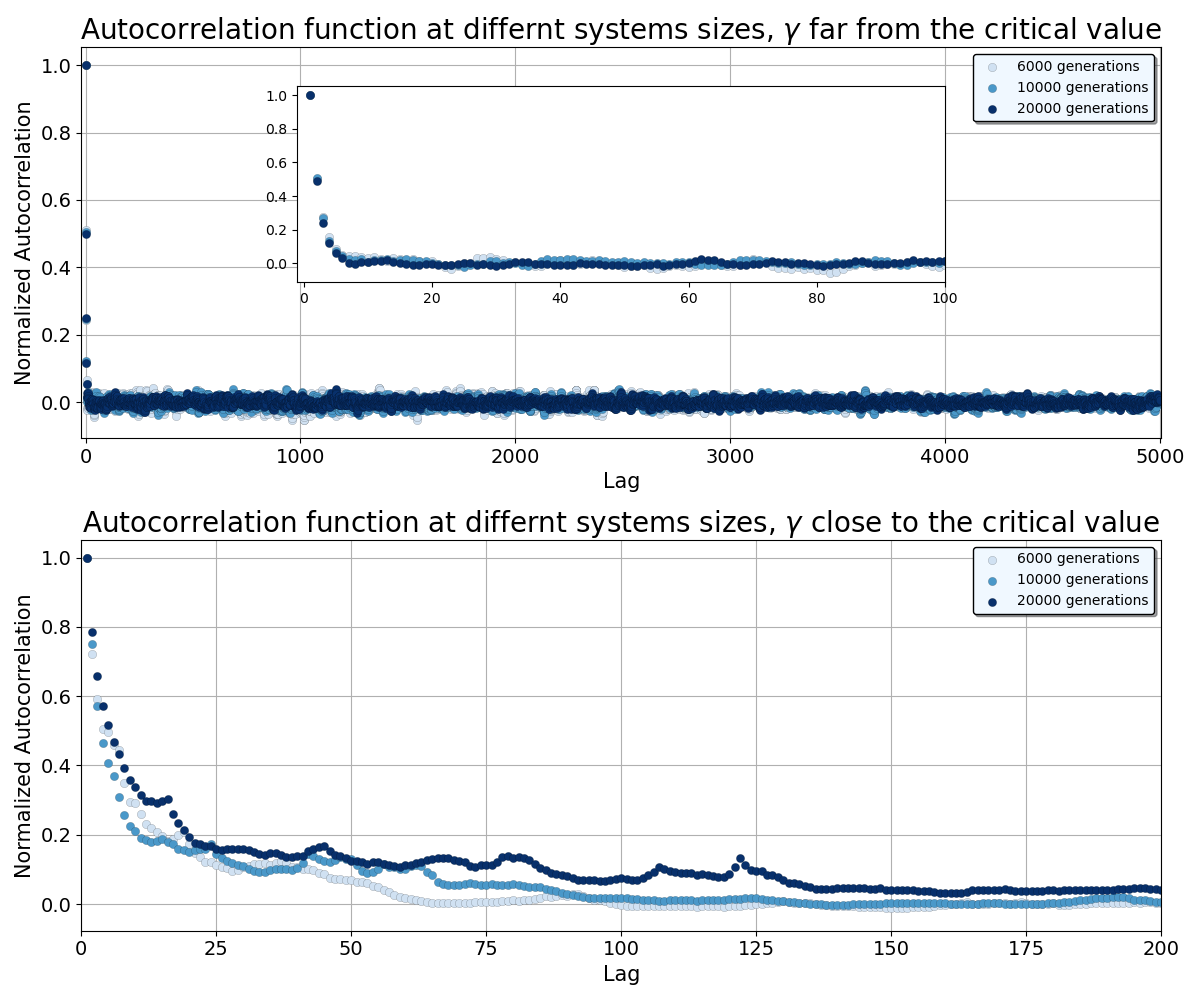

In [ ]:
fig, ax_ = plt.subplots(2,1, figsize = (12, 10))
cArr = np.zeros((len(seriesesLength), 10000))
for ax, crit , pos in zip(ax_.flatten(), [1, -1], ['far from', 'close to']):
    for i, length in enumerate(seriesesLength):
        sizesAtBirth = np.load(f'../data/longSampling/sizeBirth{length}SingleTraitSamplingM.npy')
        absorbingIdx = ~np.apply_along_axis(lambda x: np.allclose(np.zeros(10), x), axis = 1 , arr = sizesAtBirth[:,-10:])
        sizesAtBirth = sizesAtBirth[absorbingIdx,:]
        sizesAtBirth = sizesAtBirth[crit]
        autocorrelation = acf(sizesAtBirth, nlags = 5000)
        #cArr[i, :] = c
        ax.scatter(range(1, len(autocorrelation) + 1), autocorrelation, label = f'{length} generations', edgecolor = 'black', linewidth = 0.1, zorder = 2, color = colors[i])
        u_x = list(range(1, 21))
        u_y = list(autocorrelation[:20])


        #Detect peaks  and mark their location in u_x,u_y

        for k in range(1,len(autocorrelation)-20):
            signRange = [(np.sign(autocorrelation[k]-autocorrelation[k-i])==1,\
                           np.sign(autocorrelation[k]-autocorrelation[k+i])==1) for i in range(1,20)]
            if all(list(map(lambda x: (x[0] and x[1]), signRange))):
                u_x.append(k)
                u_y.append(autocorrelation[k])

        #
        # print(u_y)
        #Append the last value of to the interpolating values
        #ax.plot(u_x, u_y, color = 'red', linestyle = '--', zorder = 2, label = 'Interpolated peaks')
        popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
        #ax.plot(u_x, u_y, color = 'red')
        #ax.plot(list(range(1, len(autocorrelation) + 1)), autoCorrelationFunc(np.array(range(1, len(autocorrelation) + 1)), *popt),\
         #       color = 'red', linestyle = '--', zorder = 2)
        print(f'The correlation length found by the fit for {length} generations and gamma = {gammaValues[absorbingIdx][crit]:.4f}\
 is: {popt[1]:.3}, the power law exponent is: {popt[0]:.3}')
    ax.set_xlim(-20, 5005)
    ax.grid(zorder = 1)
    ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True, loc = 'best')
    ax.set_xlabel('Lag', fontsize = 15)
    ax.set_ylabel('Normalized Autocorrelation', fontsize = 15)
    ax.tick_params(labelsize = 14)
    ax.set_title(f'Autocorrelation function at differnt systems sizes, $\gamma$ {pos} the critical value', fontsize = 20)
ax2 = ax_[0].inset_axes([0.2, 0.4, 0.6, 0.5])
for i, length in enumerate(seriesesLength):
        sizesAtBirth = np.load(f'../data/longSampling/sizeBirth{length}SingleTraitSamplingM.npy')
        absorbingIdx = ~np.apply_along_axis(lambda x: np.allclose(np.zeros(10), x), axis = 1 , arr = sizesAtBirth[:,-10:])
        sizesAtBirth = sizesAtBirth[absorbingIdx,:]
        sizesAtBirth = sizesAtBirth[0]
        autocorrelation = acf(sizesAtBirth, nlags = 5000)
        #cArr[i, :] = c
        ax2.scatter(range(1, len(autocorrelation) + 1), autocorrelation, edgecolor = 'black', linewidth = 0.1, zorder = 2, color = colors[i])
        ax2.set_xlim(-1, 100)
ax_[1].set_xlim(0, 200)
fig.tight_layout()

In [ ]:
SizesAtBirth20000 = np.load(f'../data/longSampling/sizeBirth20000SingleTraitSamplingM.npy')
SizesAtBirth20000 = SizesAtBirth20000[:,:200]
absorbingIdx = ~np.apply_along_axis(lambda x: np.allclose(np.zeros(10), x), axis = 1 , arr = SizesAtBirth20000[:,-10:])
SizesAtBirth20000 = SizesAtBirth20000[absorbingIdx,:]


corrLengths20000 = np.zeros(SizesAtBirth20000.shape[0])
exponentN20000 = np.zeros(SizesAtBirth20000.shape[0])
for i in tqdm(range((SizesAtBirth20000.shape[0]))):
    autocorrelation = acf(SizesAtBirth20000[i], nlags = 4000)
    #ax.plot(list(range(len(autocorrelation))), autocorrelation, label = f'Generation {i}')
    u_x = list(range(1, 21))
    u_y = list(autocorrelation[:20])


    #Detect peaks  and mark their location in u_x,u_y

    for k in range(1,len(autocorrelation)-20):
        signRange = [(np.sign(autocorrelation[k]-autocorrelation[k-i])==1,\
                        np.sign(autocorrelation[k]-autocorrelation[k+i])==1) for i in range(1,20)]
        if all(list(map(lambda x: (x[0] and x[1]), signRange))):
            u_x.append(k)
            u_y.append(autocorrelation[k])
    
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    corrLengths20000[i] = popt[1]
    exponentN20000[i] = popt[0]


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


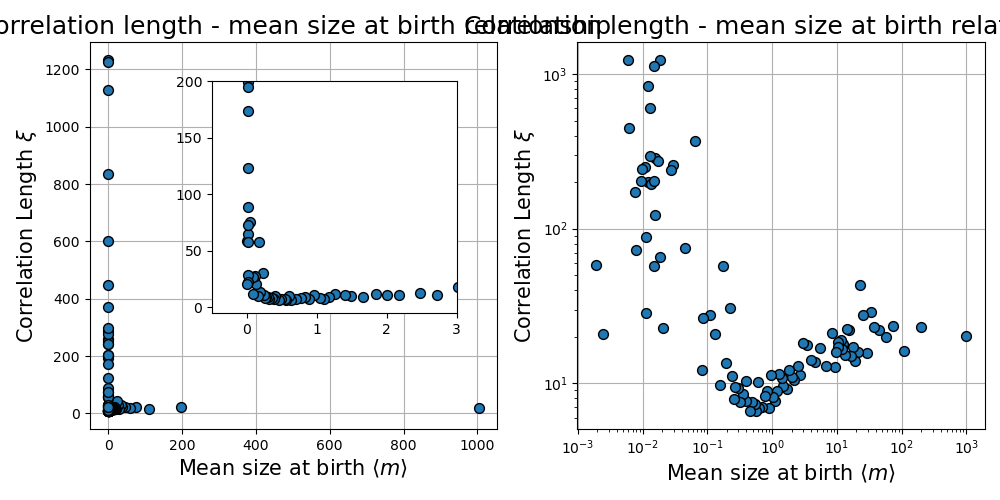

In [ ]:
fig, ax_ = plt.subplots(1, 2, figsize = (10, 5))
meanSizesAtBirth20000 = np.load(f'../data/longSampling/meanSizeBirth20000SingleTraitSamplingM.npy')
meanSizesAtBirth20000 = meanSizesAtBirth20000[absorbingIdx]
for ax, axis in zip(ax_.flatten(), ['linear', 'log']):
    ax.scatter(meanSizesAtBirth20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)
    #ax.set_ylim(bottom = bottom, top = top)
    ax.grid(zorder = 1)
    ax.set_xlabel('Mean size at birth $\\langle m \\rangle$', fontsize = 15)
    ax.set_ylabel('Correlation Length $\\xi$', fontsize = 15)
    ax.set_title('Correlation length - mean size at birth relationship', fontsize = 18)
    ax.set_xscale(axis)
    ax.set_yscale(axis)
    
ax2 = ax_[0].inset_axes([0.3, 0.3, 0.6, 0.6])
ax2.scatter(meanSizesAtBirth20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)
ax2.set_ylim(-5, 200)
ax2.set_xlim(-0.5, 3)
#ax3 = ax_[1].inset_axes([0.3, 0.3, 0.6, 0.6])
#ax3.scatter(meanSizesAtBirth20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)

#ax3.set_xscale('log')
#ax3.set_yscale('log')
#ax3.set_ylim(-5, 200)
#ax3.set_xlim(-0.5, 3)
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.tight_layout()

(0.0, 1000.0)

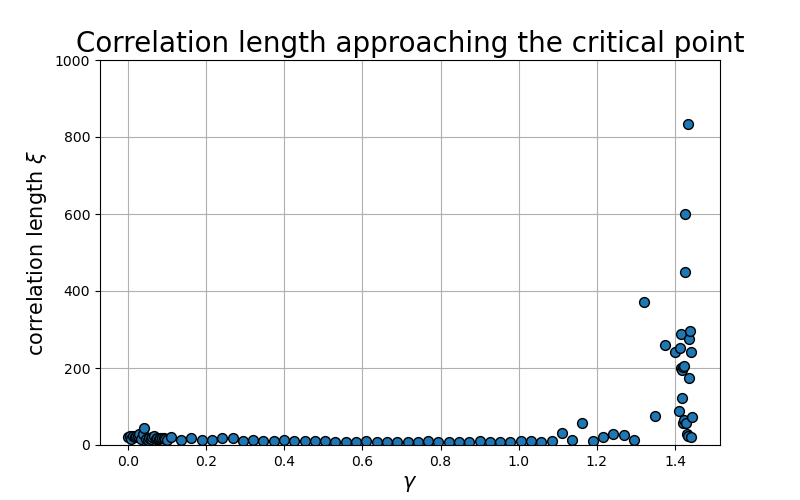

In [ ]:
limit = True
(top, bottom) = (4e4, 0) if limit else (None, None)
gammaValues20000 = gammaValues[absorbingIdx]
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(gammaValues20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)
#ax.set_ylim(top = 500, bottom = -1)
ax.grid(zorder = 1)
ax.set_xlabel('$\\gamma$', fontsize = 15)
ax.set_ylabel('correlation length $\\xi$', fontsize = 15)
ax.set_title('Correlation length approaching the critical point', fontsize = 20)


Text(0.5, 1.0, 'Exponent $\\eta$ approaching the critical point')

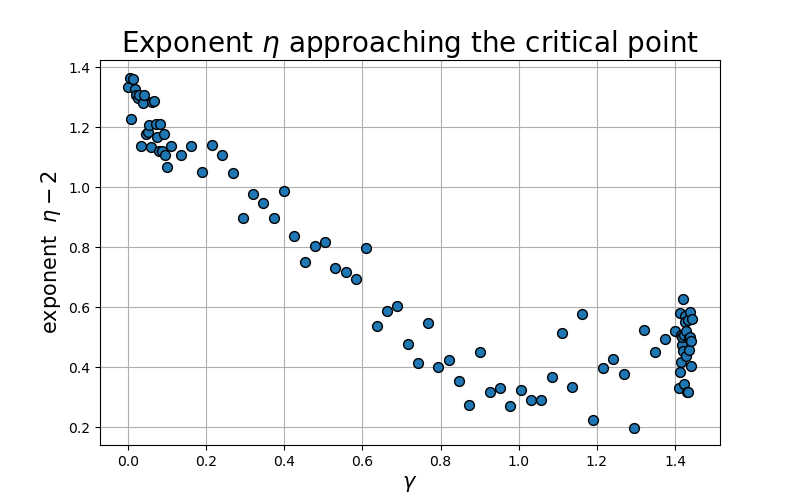

In [ ]:
limit = True
(top, bottom) = (4e4, 0) if limit else (None, None)
absorbingThreshold = 34

fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(gammaValues, exponentN20000, edgecolor = 'black', s = 50, zorder = 2)
#ax.set_ylim(bottom = bottom,top = top)
ax.grid(zorder = 1)
ax.set_xlabel('$\\gamma$', fontsize = 15)
ax.set_ylabel('exponent  $\\eta - 2$', fontsize = 15)
ax.set_title('Exponent $\\eta$ approaching the critical point', fontsize = 20)


Text(0, 0.5, 'Normalized $acf$')

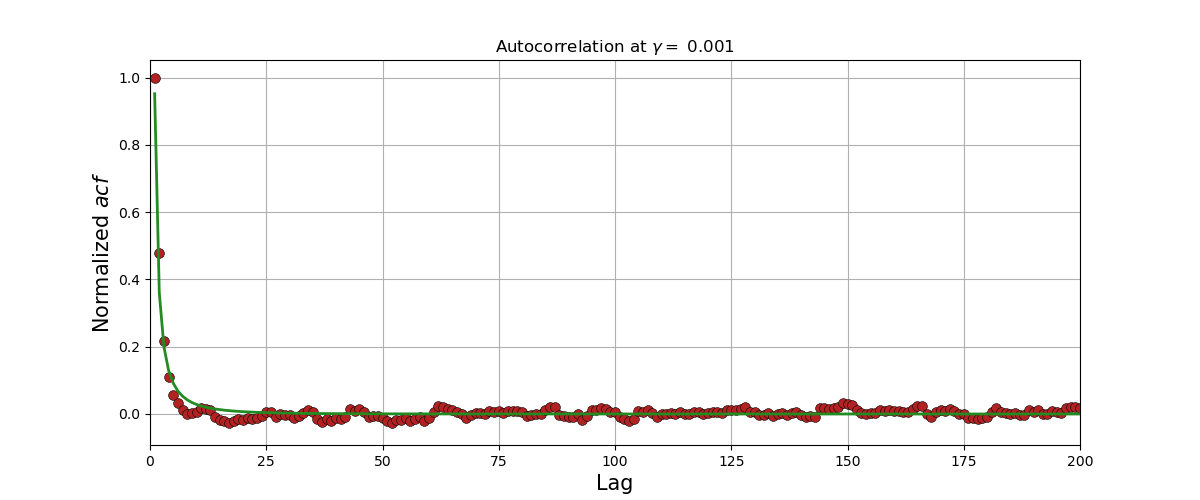

In [ ]:
%matplotlib ipympl
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
def fY (x, gamma):
    global title 
    title = f'Autocorrelation at $\\gamma = $ {gamma:.3f}'
    ax.set_title(title)
    idxGamma = list(gammaValues20000).index(gamma)
    autocorrelation = acf(SizesAtBirth20000[idxGamma], nlags = 9000)
    return autocorrelation

def fY2 (x, gamma):
    idxGamma = list(gammaValues20000).index(gamma)
    autocorrelation = acf(SizesAtBirth20000[idxGamma], nlags = 9000)
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
  
    return autoCorrelationFunc(np.array(range(1, len(autocorrelation) + 1)), *popt)


controls = iplt.scatter(range(1, 9002), fY, gamma = gammaValues20000, edgecolor = 'black', s = 50, zorder = 2, color = 'firebrick',\
                         linewidth = 0.4)

_ = iplt.plot(range(1, 9002), fY2, controls=controls, color = 'forestgreen', linewidth = 2)
ax.grid(zorder = 1)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Normalized $acf$', fontsize = 15)
